In [43]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [44]:
data = pd.read_csv("epl_22_23.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [45]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.matchId==next_actions.matchId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['matchId' ] = nex.matchId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team_name','playerName','h_a']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['playerName' ]= nex.playerName
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['matchId','period','action_id']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [46]:
data = add_carries(data)

In [47]:
data_andre = data[data['playerId'] == 345319]

In [48]:
data_passes = data_andre[data_andre['type'] == 'Pass']

In [49]:
data_succ = data_passes[data_passes['outcomeType'] == 'Successful']
data_unsucc = data_passes[data_passes['outcomeType'] == 'Unsuccessful']

data_succ_prog = data_succ.reset_index()
data_unsucc_prog = data_unsucc.reset_index()
data_succ_prog['beginning'] = np.sqrt(np.square(120-data_succ_prog['x']) + np.square(40 - data_succ_prog['y']))
data_succ_prog['end'] = np.sqrt(np.square(120 - data_succ_prog['endX']) + np.square(40 - data_succ_prog['endY']))

data_succ_prog['progressive'] = [(data_succ_prog['end'][x]) / (data_succ_prog['beginning'][x]) < .75 for x in range(len(data_succ_prog.beginning))]
data_succ_prog = data_succ_prog[data_succ_prog['progressive'] == True]

In [50]:
data_carries = data_andre[data_andre['type'] == 'Carry']

data_carries_succ = data_carries[data_carries['outcomeType'] == 'Successful']
data_carries_unsucc = data_carries[data_carries['outcomeType'] == 'Unsuccessful']

data_carries_succ_prog = data_carries_succ.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()

data_carries_succ_prog['beginning'] = np.sqrt(np.square(120-data_carries_succ_prog['x']) + np.square(40 - data_carries_succ_prog['y']))
data_carries_succ_prog['end'] = np.sqrt(np.square(120 - data_carries_succ_prog['endX']) + np.square(40 - data_carries_succ_prog['endY']))

data_carries_succ_prog['progressive'] = [(data_carries_succ_prog['end'][x]) / (data_carries_succ_prog['beginning'][x]) < .75 for x in range(len(data_carries_succ_prog.beginning))]
data_carries_succ_prog = data_carries_succ_prog[data_carries_succ_prog['progressive'] == True]

In [51]:
data_succ_prog = data_succ_prog[data_succ_prog['passCorner'] == False]

In [52]:
left_halfspace_x_min = 60
left_halfspace_x_max = 60 + 42
left_halfspace_y_min = 50
left_halfspace_y_max = 50 + 12
    
    
right_halfspace_x_min = 60
right_halfspace_x_max = 60 + 42
right_halfspace_y_min = 18
right_halfspace_y_max = 18 + 12

In [53]:
# Add 'in_rhs' column to data_succ_prog
data_succ['in_rhs'] = (data_succ['x'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                       data_succ['y'].between(right_halfspace_y_min, right_halfspace_y_max))

# Add 'in_lhs' column to data_succ_prog
data_succ['in_lhs'] = (data_succ['x'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                       data_succ['y'].between(left_halfspace_y_min, left_halfspace_y_max))

# Add 'into_rhs' column to data_succ_prog
data_succ['into_rhs'] = (data_succ['endX'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                         data_succ['endY'].between(right_halfspace_y_min, right_halfspace_y_max) & 
                         (data_succ['in_rhs'] == False))

# Add 'into_lhs' column to data_succ_prog
data_succ['into_lhs'] = (data_succ['endX'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                         data_succ['endY'].between(left_halfspace_y_min, left_halfspace_y_max) & 
                         (data_succ['in_lhs'] == False))

# Add 'in_rhs' column to data_carries_succ_prog
data_carries['in_rhs'] = (data_carries['x'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                          data_carries['y'].between(right_halfspace_y_min, right_halfspace_y_max))

# Add 'in_lhs' column to data_carries_succ_prog
data_carries['in_lhs'] = (data_carries['x'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                          data_carries['y'].between(left_halfspace_y_min, left_halfspace_y_max))

# Add 'into_rhs' column to data_carries_succ_prog
data_carries['into_rhs'] = (data_carries['endX'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                            data_carries['endY'].between(right_halfspace_y_min, right_halfspace_y_max) & 
                            (data_carries['in_rhs'] == False))

# Add 'into_lhs' column to data_carries_succ_prog
data_carries['into_lhs'] = (data_carries['endX'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                            data_carries['endY'].between(left_halfspace_y_min, left_halfspace_y_max) & 
                            (data_carries['in_lhs'] == False))


C:\Users\91852\AppData\Local\Temp/ipykernel_12152/1300576269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_succ['in_rhs'] = (data_succ['x'].between(right_halfspace_x_min, right_halfspace_x_max) &
C:\Users\91852\AppData\Local\Temp/ipykernel_12152/1300576269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_succ['in_lhs'] = (data_succ['x'].between(left_halfspace_x_min, left_halfspace_x_max) &
C:\Users\91852\AppData\Local\Temp/ipykernel_12152/1300576269.py:10: SettingWithCopyWarning: 
A value

In [54]:
data_carries_in_rhs = data_carries[data_carries['in_rhs'] == True]
data_carries_into_rhs = data_carries[data_carries['into_rhs'] == True]
data_carries_in_lhs = data_carries[data_carries['in_lhs'] == True]
data_carries_into_lhs = data_carries[data_carries['into_lhs'] == True]


data_succ_pass_into_rhs = data_succ[data_succ['into_rhs'] == True]
data_succ_pass_in_rhs = data_succ[data_succ['in_rhs'] == True]
data_succ_pass_into_lhs = data_succ[data_succ['into_lhs'] == True]
data_succ_pass_in_lhs = data_succ[data_succ['in_lhs'] == True]


In [55]:
passes_out_lhs = data_succ_pass_into_lhs['x'].count()
passes_out_rhs = data_succ_pass_into_rhs['x'].count()
total_pass_into = passes_out_lhs + passes_out_rhs

In [56]:
total

70

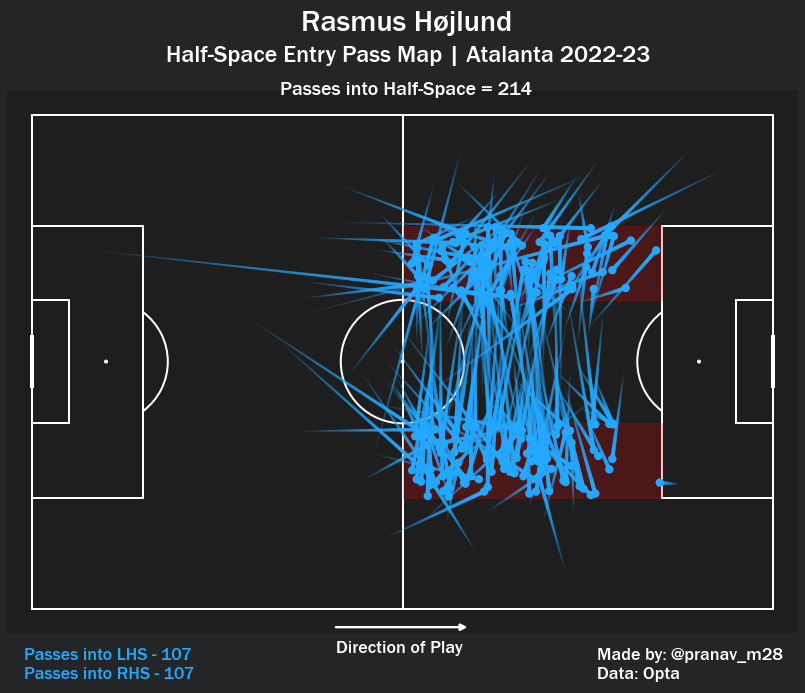

In [57]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 10),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

#Plotting Passes into LHS

lc1 = pitch.lines(data_succ_pass_into_lhs.x, data_succ_pass_into_lhs.y,
                  data_succ_pass_into_lhs.endX, data_succ_pass_into_lhs.endY,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#24a8ff', ax=ax)

pitch.scatter(data_succ_pass_into_lhs.endX, data_succ_pass_into_lhs.endY, s=70,
              marker='o', edgecolors='none', c='#24a8ff', zorder=2,
              label='goal', ax=ax , alpha=1)


#Plotting Passes into RHS

lc1 = pitch.lines(data_succ_pass_into_rhs.x, data_succ_pass_into_rhs.y,
                  data_succ_pass_into_rhs.endX, data_succ_pass_into_rhs.endY,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#24a8ff', ax=ax)

pitch.scatter(data_succ_pass_into_rhs.endX, data_succ_pass_into_rhs.endY, s=70,
              marker='o', edgecolors='none', c='#24a8ff', zorder=2,
              label='goal', ax=ax , alpha=1)

plt.gca().invert_yaxis()

# Highlight Zone 14
#zone14_rectangle = plt.Rectangle((78, 30), 24, 20, color='yellow', alpha=0.2)

#ax.add_patch(zone14_rectangle)

# Highlight Left Half-Space
left_halfspace_rectangle = plt.Rectangle((60, 50), 42, 12, color='red', alpha=0.2)
ax.add_patch(left_halfspace_rectangle)

# Highlight Right Half-Space
right_halfspace_rectangle = plt.Rectangle((60, 18), 42, 12, color='red', alpha=0.2)
ax.add_patch(right_halfspace_rectangle)



fig_text(
    0.516, 0.99, "<Rasmus Højlund>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Half-Space Entry Pass Map | Atalanta 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.516, 0.892,
    f"Passes into Half-Space = {total_pass_into}",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.250, 0.105, f"<Passes into LHS - {passes_out_lhs}>\n<Passes into RHS - {passes_out_rhs}>",
    font='Franklin Gothic Medium', size=18,
    ha="center", color="#FFFFFF", fontweight='bold',
    highlight_textprops=[{"color": '#24a8ff'}, {"color": '#24a8ff'}]
)


plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.115, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('Hojlund Zone 14 Out.png' , dpi=300 , bbox_inches='tight')

In [58]:
carries_out_lhs = data_carries_into_lhs['x'].count()
carries_out_rhs = data_carries_into_rhs['x'].count()
total_carr_in = carries_out_lhs + carries_out_rhs

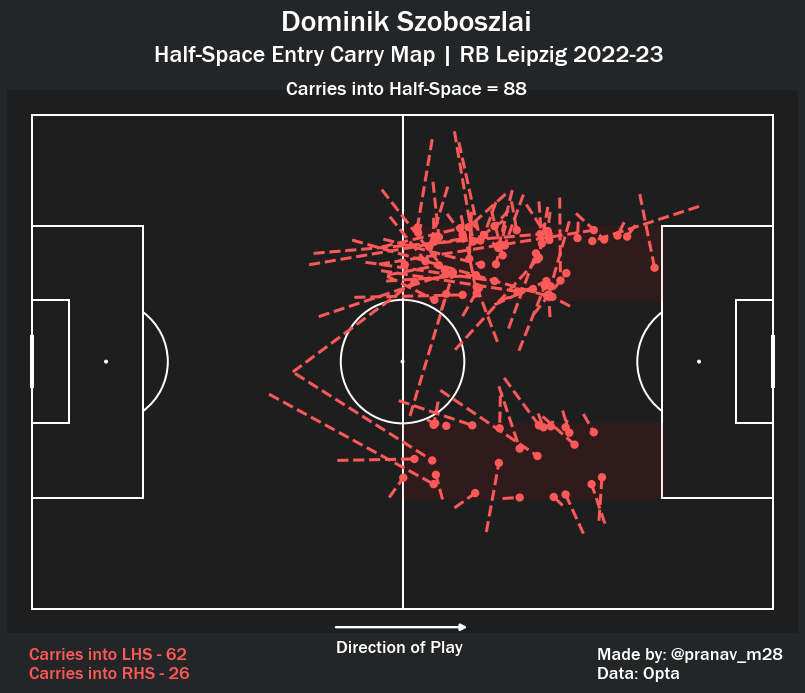

In [59]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 10),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

#Plotting Carries into LHS

lc1 = pitch.lines(data_carries_into_lhs.x, data_carries_into_lhs.y,
                  data_carries_into_lhs.endX, data_carries_into_lhs.endY,ls='dashed',
                  lw=3, transparent=False, comet=False, label='completed passes',
                  color='#FF5959', ax=ax)

pitch.scatter(data_carries_into_lhs.endX, data_carries_into_lhs.endY, s=70,
              marker='o', edgecolors='none', c='#FF5959', zorder=2,
              label='goal', ax=ax , alpha=1)


#Plotting Carries into RHS

lc1 = pitch.lines(data_carries_into_rhs.x, data_carries_into_rhs.y,
                  data_carries_into_rhs.endX, data_carries_into_rhs.endY,ls='dashed',
                  lw=3, transparent=False, comet=False, label='completed passes',
                  color='#FF5959', ax=ax)

pitch.scatter(data_carries_into_rhs.endX, data_carries_into_rhs.endY, s=70,
              marker='o', edgecolors='none', c='#FF5959', zorder=2,
              label='goal', ax=ax , alpha=1)

plt.gca().invert_yaxis()

# Highlight Zone 14
#zone14_rectangle = plt.Rectangle((78, 30), 24, 20, color='yellow', alpha=0.2)

#ax.add_patch(zone14_rectangle)

# Highlight Left Half-Space
left_halfspace_rectangle = plt.Rectangle((60, 50), 42, 12, color='red', alpha=0.08)
ax.add_patch(left_halfspace_rectangle)

# Highlight Right Half-Space
right_halfspace_rectangle = plt.Rectangle((60, 18), 42, 12, color='red', alpha=0.08)
ax.add_patch(right_halfspace_rectangle)



fig_text(
    0.516, 0.99, "<Dominik Szoboszlai>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Half-Space Entry Carry Map | RB Leipzig 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.516, 0.892,
    f"Carries into Half-Space = {total_carr_in}",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.250, 0.105, f"<Carries into LHS - {carries_out_lhs}>\n<Carries into RHS - {carries_out_rhs}>",
    font='Franklin Gothic Medium', size=18,
    ha="center", color="#FFFFFF", fontweight='bold',
    highlight_textprops=[{"color": '#FF5959'}, {"color": '#FF5959'}]
)


plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.115, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('Szobo Half Space Carry Entry Map.png' , dpi=300 , bbox_inches='tight')

In [60]:
passes_inside_lhs = data_succ_pass_in_lhs['x'].count()
passes_inside_rhs = data_succ_pass_in_rhs['x'].count()
total_pass_inside = passes_inside_lhs + passes_inside_rhs

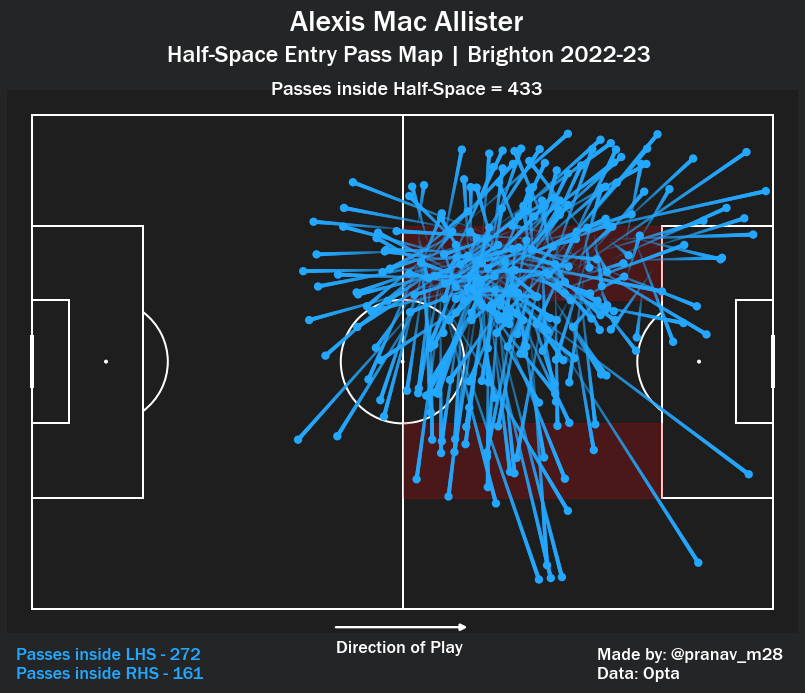

In [66]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 10),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

#Plotting Passes in LHS

lc1 = pitch.lines(data_succ_pass_in_lhs.x, data_succ_pass_in_lhs.y,
                  data_succ_pass_in_lhs.endX, data_succ_pass_in_lhs.endY,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#24a8ff', ax=ax)

pitch.scatter(data_succ_pass_in_lhs.endX, data_succ_pass_in_lhs.endY, s=70,
              marker='o', edgecolors='none', c='#24a8ff', zorder=2,
              label='goal', ax=ax , alpha=1)


#Plotting Passes in RHS

#lc1 = pitch.lines(data_succ_pass_in_rhs.x, data_succ_pass_in_rhs.y,
 #                 data_succ_pass_in_rhs.endX, data_succ_pass_in_rhs.endY,
  #                lw=4, transparent=True, comet=True, label='completed passes',
   #               color='#24a8ff', ax=ax)

#pitch.scatter(data_succ_pass_in_rhs.endX, data_succ_pass_in_rhs.endY, s=70,
 #             marker='o', edgecolors='none', c='#24a8ff', zorder=2,
  #            label='goal', ax=ax , alpha=1)

plt.gca().invert_yaxis()

# Highlight Zone 14
#zone14_rectangle = plt.Rectangle((78, 30), 24, 20, color='yellow', alpha=0.2)

#ax.add_patch(zone14_rectangle)

# Highlight Left Half-Space
left_halfspace_rectangle = plt.Rectangle((60, 50), 42, 12, color='red', alpha=0.2)
ax.add_patch(left_halfspace_rectangle)

# Highlight Right Half-Space
right_halfspace_rectangle = plt.Rectangle((60, 18), 42, 12, color='red', alpha=0.2)
ax.add_patch(right_halfspace_rectangle)



fig_text(
    0.516, 0.99, "<Alexis Mac Allister>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Half-Space Entry Pass Map | Brighton 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.516, 0.892,
    f"Passes inside Half-Space = {total_pass_inside}",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.250, 0.105, f"<Passes inside LHS - {passes_inside_lhs}>\n<Passes inside RHS - {passes_inside_rhs}>",
    font='Franklin Gothic Medium', size=18,
    ha="center", color="#FFFFFF", fontweight='bold',
    highlight_textprops=[{"color": '#24a8ff'}, {"color": '#24a8ff'}]
)


plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.115, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('AMA Left Half-Space Passes.png' , dpi=300 , bbox_inches='tight')

In [62]:
carries_inside_lhs = data_carries_in_lhs['x'].count()
carries_inside_rhs = data_carries_in_rhs['x'].count()
total_carries_inside = carries_inside_lhs + carries_inside_rhs

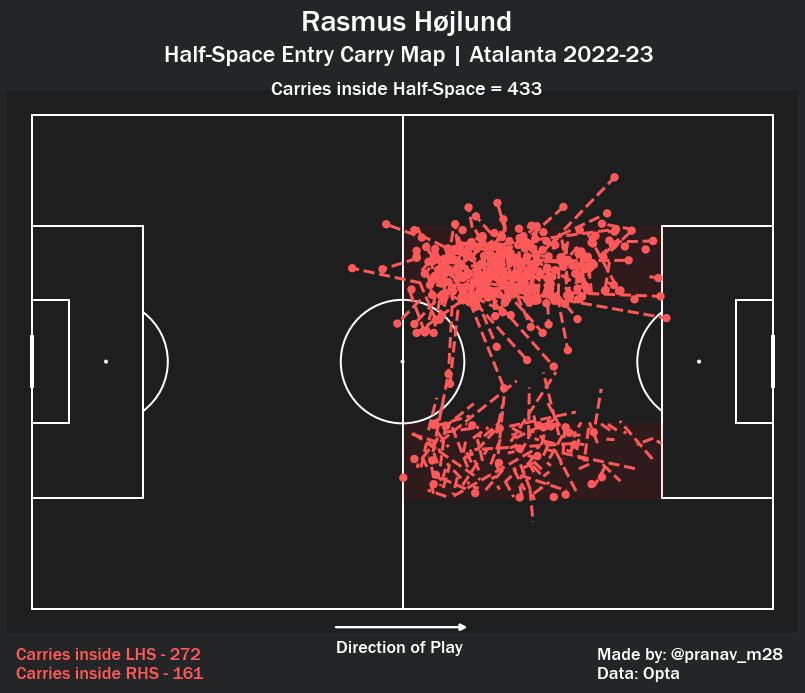

In [63]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 10),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

#Plotting Carries into LHS

lc1 = pitch.lines(data_carries_in_lhs.x, data_carries_in_lhs.y,
                  data_carries_in_lhs.endX, data_carries_in_lhs.endY,ls='dashed',
                  lw=3, transparent=False, comet=False, label='completed passes',
                  color='#FF5959', ax=ax)

pitch.scatter(data_carries_in_lhs.endX, data_carries_in_lhs.endY, s=70,
              marker='o', edgecolors='none', c='#FF5959', zorder=2,
              label='goal', ax=ax , alpha=1)


#Plotting Carries into RHS

lc1 = pitch.lines(data_carries_in_rhs.x, data_carries_in_rhs.y,
                  data_carries_in_rhs.endX, data_carries_in_rhs.endY,ls='dashed',
                  lw=3, transparent=False, comet=False, label='completed passes',
                  color='#FF5959', ax=ax)

pitch.scatter(data_carries_into_rhs.endX, data_carries_into_rhs.endY, s=70,
              marker='o', edgecolors='none', c='#FF5959', zorder=2,
              label='goal', ax=ax , alpha=1)

plt.gca().invert_yaxis()

# Highlight Zone 14
#zone14_rectangle = plt.Rectangle((78, 30), 24, 20, color='yellow', alpha=0.2)

#ax.add_patch(zone14_rectangle)

# Highlight Left Half-Space
left_halfspace_rectangle = plt.Rectangle((60, 50), 42, 12, color='red', alpha=0.08)
ax.add_patch(left_halfspace_rectangle)

# Highlight Right Half-Space
right_halfspace_rectangle = plt.Rectangle((60, 18), 42, 12, color='red', alpha=0.08)
ax.add_patch(right_halfspace_rectangle)



fig_text(
    0.516, 0.99, "<Rasmus Højlund>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Half-Space Entry Carry Map | Atalanta 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.516, 0.892,
    f"Carries inside Half-Space = {total_carries_inside}",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.250, 0.105, f"<Carries inside LHS - {carries_inside_lhs}>\n<Carries inside RHS - {carries_inside_rhs}>",
    font='Franklin Gothic Medium', size=18,
    ha="center", color="#FFFFFF", fontweight='bold',
    highlight_textprops=[{"color": '#FF5959'}, {"color": '#FF5959'}]
)


plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.115, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('Hojlund Zone 14 Out.png' , dpi=300 , bbox_inches='tight')